In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import yfinance as yf

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/admin1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/admin1/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
twitter_df = pd.read_csv("Twitter_Data.csv")
reddit_df = pd.read_csv("Reddit_Data.csv")

In [4]:
twitter_df = twitter_df.rename(columns={
    "clean_text": "text",
    "category": "sentiment"
})

reddit_df = reddit_df.rename(columns={
    "clean_comment": "text",
    "category": "sentiment"
})

In [5]:
# Select required columns
twitter_df = twitter_df[['text', 'sentiment']]
reddit_df = reddit_df[['text', 'sentiment']]

In [6]:
# Combine
df = pd.concat([twitter_df, reddit_df], ignore_index=True)
df.dropna(inplace=True)

#### Text Preprocessing

In [10]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(words)

df['clean_text'] = df['text'].apply(clean_text)

In [15]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['clean_text'])
y = df['sentiment']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [17]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [18]:
y_pred = model.predict(X_test)

In [19]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8853437937237657
              precision    recall  f1-score   support

        -1.0       0.86      0.77      0.81      8615
         0.0       0.86      0.96      0.91     13630
         1.0       0.92      0.88      0.90     17779

    accuracy                           0.89     40024
   macro avg       0.88      0.87      0.87     40024
weighted avg       0.89      0.89      0.88     40024



In [20]:
# Re-transform full dataset (IMPORTANT)
X_full = vectorizer.transform(df['clean_text'])

# Predict sentiment for full dataset
df['predicted_sentiment'] = model.predict(X_full)

print("Prediction length:", len(df['predicted_sentiment']))
print("Dataframe length:", len(df))

Prediction length: 200118
Dataframe length: 200118


In [21]:
# Reset index
df = df.reset_index(drop=True)

# Create group number (1000 tweets per day)
df['day_number'] = df.index // 1000

# Convert to actual date
start_date = pd.to_datetime("2022-01-01")
df['Date'] = start_date + pd.to_timedelta(df['day_number'], unit='D')

# Now calculate daily sentiment
daily_sentiment = df.groupby('Date')['predicted_sentiment'].mean()

print(daily_sentiment.head())

Date
2022-01-01    0.215
2022-01-02    0.248
2022-01-03    0.222
2022-01-04    0.165
2022-01-05    0.191
Name: predicted_sentiment, dtype: float64


In [36]:
stock = yf.download("TSLA", start="2022-01-01", end="2023-12-31")

# Flatten multi-level columns
stock.columns = stock.columns.get_level_values(0)

# Keep required columns
stock = stock[['Close']]

# Calculate returns
stock['Returns'] = stock['Close'].pct_change()

stock.dropna(inplace=True)
stock.reset_index(inplace=True)

print(stock.head())

[*********************100%***********************]  1 of 1 completed

Price       Date       Close   Returns
0     2022-01-04  383.196655 -0.041833
1     2022-01-05  362.706665 -0.053471
2     2022-01-06  354.899994 -0.021523
3     2022-01-07  342.320007 -0.035447
4     2022-01-10  352.706665  0.030342


In [38]:
# Make sure both Date columns are datetime
stock['Date'] = pd.to_datetime(stock['Date'])
daily_sentiment['Date'] = pd.to_datetime(daily_sentiment['Date'])

# Merge
merged = pd.merge(stock, daily_sentiment,
                  on="Date",
                  how="inner")

print("Correlation:",
      merged['Returns'].corr(merged['predicted_sentiment']))

Correlation: 0.0583968599279774


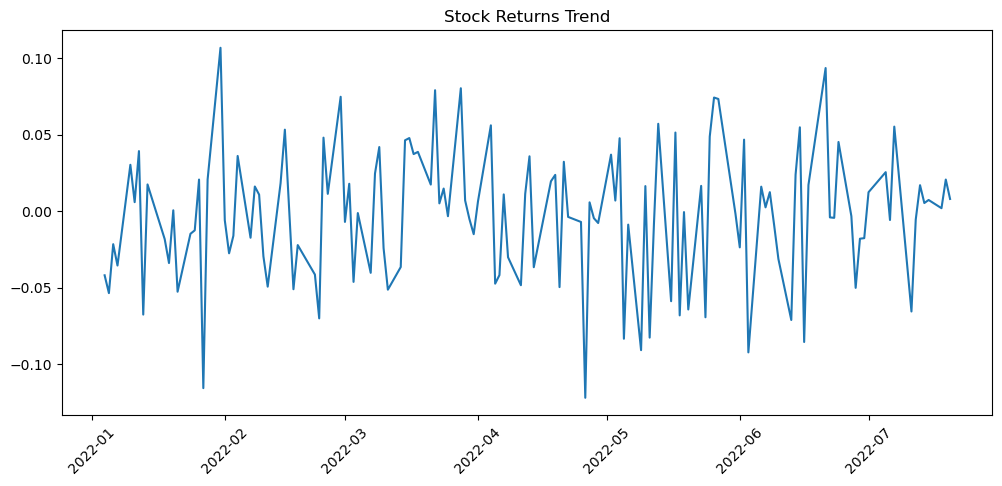

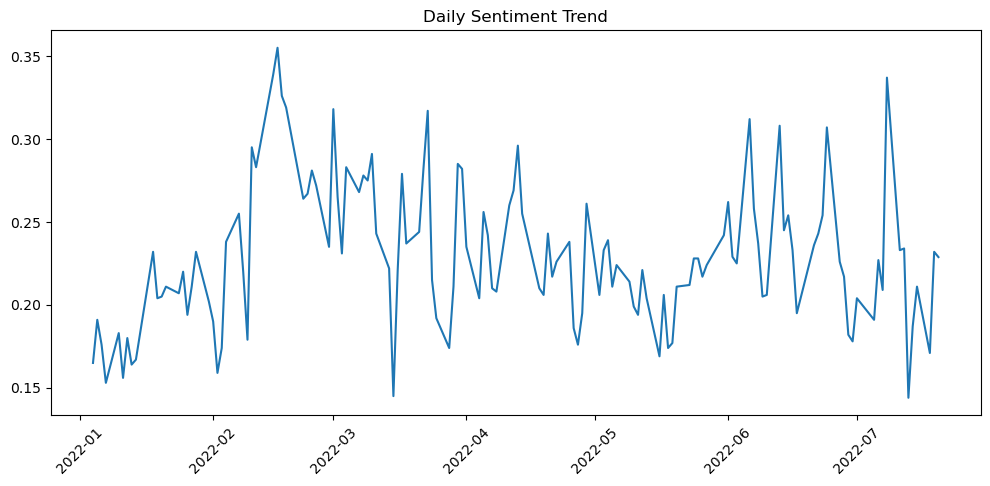

In [40]:
plt.figure(figsize=(12,5))
plt.plot(merged['Date'], merged['Returns'])
plt.title("Stock Returns Trend")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12,5))
plt.plot(merged['Date'], merged['predicted_sentiment'])
plt.title("Daily Sentiment Trend")
plt.xticks(rotation=45)
plt.show()